In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [94]:
def bit_error_rate(y_true, y_pred):
    true = ''.join([f"{sym:04b}" for sym in np.array(y_true)])
    pred = ''.join([f"{sym:04b}" for sym in np.array(y_pred)])
    # Calculate BER (bit error rate) of the constellation (true vs pred)
    ber = sum([1 for i in range(len(true)) if true[i] != pred[i]]) / len(true)
    return ber

def demodulate_16QAM(signal):
    mod_dict = {-3+3j: 0, -3+1j: 1, -3-3j: 2, -3-1j: 3,
                -1+3j: 4, -1+1j: 5, -1-3j: 6, -1-1j: 7,
                3+3j: 8, 3+1j: 9, 3-3j: 10, 3-1j: 11,
                1+3j: 12, 1+1j: 13, 1-3j: 14, 1-1j: 15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
    return symbols

def synchronize_signals(tx_signal, rx_signal):
    tx = np.concatenate((tx_signal, tx_signal))
    corr = np.abs(np.correlate(np.abs(tx) - np.mean(np.abs(tx)),
                  np.abs(rx_signal) - np.mean(np.abs(rx_signal)), mode='full'))
    delay = np.argmax(corr) - len(rx_signal) + 1
    signal = tx[delay:]
    signal = signal[:len(rx_signal)]
    signal_demod = demodulate_16QAM(signal)
    return signal_demod

In [95]:
tx_dir = "DB_EXP/2x16QAM_16GBd.csv"
tx = np.loadtxt(tx_dir, delimiter=',', skiprows=1)
tx_complex = tx[:, 0] + 1j * tx[:, 1]

In [96]:
# osnr = [14.3, 15.3, 16.3, 17.8, 19.3, 21.3, 23.3, 26.3, 28.3, 31.3, 36.3]; spacing = "single_ch"
# osnr = [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40]; spacing = "17GHz_spacing"
osnr = [40]; spacing = "15.5GHz_spacing"

In [97]:
X = np.array([np.loadtxt(f"DB_EXP/{spacing}/16QAM_3x16GBd_consY{i}dB.csv", delimiter=',', skiprows=1) for i in osnr])
X_complex = X[:, :, 0] + 1j * X[:, :, 1]

In [98]:
y = np.array([synchronize_signals(tx_complex, X_complex[i]) for i in range(len(osnr))])

In [99]:
max_depth = [2, 3, 5, 7, 9, 15, 25, 50, 100]
min_samples_leaf = [2, 3, 5, 10, 20, 50, 100, 200, 500]

df = pd.DataFrame(columns=['max_depth', 'min_samples_leaf', 'BER'])
for i in max_depth:
    for j in min_samples_leaf:
        for k in range(len(osnr)):
            X_train, X_test, y_train, y_test = train_test_split(X[k], y[k], test_size=0.2, random_state=42)
            clf = DecisionTreeClassifier(max_depth=i, min_samples_split=j, criterion='entropy').fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            ber = bit_error_rate(y_test, y_pred)
            arr = np.array([i, j, ber])
            df.loc[len(df)] = arr

df.to_csv(f"ber_15.5GHz_{osnr[k]}dB_2.csv", index=False)

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ber_df = pd.read_csv("ber_15.5GHz_40dB_2.csv")

ber = [
    ber_df.loc[ber_df['min_samples_leaf'] == 2],
    ber_df.loc[ber_df['min_samples_leaf'] == 3],
    ber_df.loc[ber_df['min_samples_leaf'] == 5],
    ber_df.loc[ber_df['min_samples_leaf'] == 10],
    ber_df.loc[ber_df['min_samples_leaf'] == 20],
    ber_df.loc[ber_df['min_samples_leaf'] == 50],
    ber_df.loc[ber_df['min_samples_leaf'] == 100],
    ber_df.loc[ber_df['min_samples_leaf'] == 200],
    ber_df.loc[ber_df['min_samples_leaf'] == 500]
]


In [108]:
# colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'gray', 'pink', 'brown', 'orange']
colors = ['red', 'gray', 'orange', 'yellow', 'magenta', 'cyan', 'pink', 'blue', 'green']
markers = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
linestyle = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']

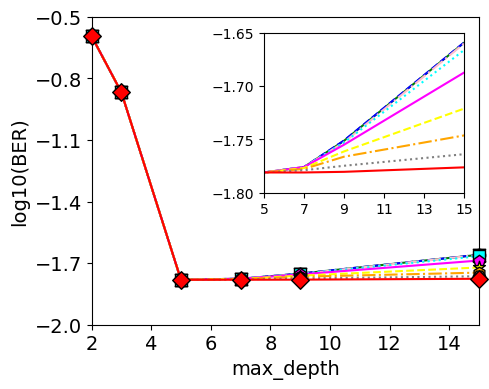

In [121]:
plt.figure(figsize=(5, 4))
min_samples_leaf = [2, 3, 5, 10, 20, 50, 100, 200, 500]
for i in range(len(min_samples_leaf)):
    plt.scatter(ber[i]['max_depth'], np.log10(ber[i]['BER']), marker=markers[i], color=colors[8-i], 
            s=80, edgecolors='black', label=f"{min_samples_leaf[i]}", 
            zorder=3, clip_on=False)
    plt.plot(ber[i]['max_depth'], np.log10(ber[i]['BER']), color=colors[8-i], label=" ", linestyle=linestyle[i], zorder=2)
plt.xlabel('max_depth', fontsize=14)
plt.ylabel('log10(BER)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([2, 15])
plt.ylim([-2, -0.5])
plt.yticks([-2, -1.7, -1.4, -1.1, -0.8, -0.5])
# plt.legend(bbox_to_anchor=(1.7, 0.5), loc="center right", ncol=3)

ax_zoom = plt.axes([0.47, 0.44, 0.4, 0.4])
for i in range(len(min_samples_leaf)):
    ax_zoom.plot(ber[i]['max_depth'], np.log10(ber[i]['BER']), color=colors[8-i], label=" ", linestyle=linestyle[i], zorder=2)
ax_zoom.set_xlim([5, 15])
ax_zoom.set_ylim([-1.8, -1.65])
ax_zoom.set_xticks([5, 7, 9, 11, 13, 15])
ax_zoom.set_yticks([-1.8, -1.75, -1.7, -1.65])

plt.savefig("ber_15.5GHz_40dB.svg", bbox_inches='tight', pad_inches=0.1, format='svg')
plt.show()